In [1]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Input, \
                    add, AveragePooling2D
from keras.optimizers import SGD
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
NUMBER_OF_CLASSES = 100
epochs = 200
batch_size = 100
path_best = "gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization.h5"
# path_best = "../weights/Resnet18_SGD_NoRegularization.h5"
path_train = "gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization_2.h5" 

In [4]:
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

y_train_norm = to_categorical(y_train, NUMBER_OF_CLASSES)
y_test_norm = to_categorical(y_test, NUMBER_OF_CLASSES)

y_test = y_test.flatten()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train_norm = (x_train-mean)/(std+1e-7)
x_test_norm = (x_test-mean)/(std+1e-7)

In [5]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train_norm)

In [6]:
def resnetBuilder(l, filters):
    x = l

    l = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(l)
    l = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(l)

    x = Conv2D(filters=filters, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = add([x,l])
    x = Activation('relu')(x)

    return x 

In [7]:
def createResnetModel():
    input = Input(shape=(32,32,3))
    l = Conv2D(filters=64, kernel_size=(7,7), padding="same")(input)
    l = Activation('relu')(l)
    l = MaxPool2D(pool_size=(3,3))(l)

    l = resnetBuilder(l, 64)
    l = resnetBuilder(l, 64)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 512)
    l = resnetBuilder(l, 512)

    l = AveragePooling2D(pool_size=(8,8))(l)
    l = Flatten()(l)
    output = Dense(NUMBER_OF_CLASSES, activation='softmax')(l)

    model = Model(inputs=input, outputs=output)
    return model

In [8]:
model = createResnetModel()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 10, 64)   0           activation[0][0]                 
_______________________________________________________________________________________

In [9]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

**Training**

In [11]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [12]:
history = model.fit(datagen.flow(x_train_norm, y_train_norm,
                                        batch_size=batch_size),
                        steps_per_epoch=x_train_norm.shape[0]// batch_size,
                        epochs=epochs,
                        validation_data=(x_test_norm,y_test_norm),
                        callbacks=[checkpoint, early],verbose=2)

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.06910, saving model to gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization_2.h5
500/500 - 63s - loss: 4.3698 - accuracy: 0.0281 - val_loss: 4.0166 - val_accuracy: 0.0691
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.06910 to 0.14960, saving model to gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization_2.h5
500/500 - 63s - loss: 3.8333 - accuracy: 0.0999 - val_loss: 3.5775 - val_accuracy: 0.1496
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.14960 to 0.19420, saving model to gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization_2.h5
500/500 - 63s - loss: 3.4513 - accuracy: 0.1683 - val_loss: 3.2830 - val_accuracy: 0.1942
Epoch 4/200

Epoch 00004: val_accuracy improved from 0.19420 to 0.27730, saving model to gdrive/My Drive/Colab Notebooks/Resnet18_SGD_NoRegularization_2.h5
500/500 - 63s - loss: 3.1310 - accuracy: 0.2306 - val_loss: 2.9221 - val_accuracy: 0.2773
Epoch 5/200

Epoch 

*Plotting training accuracy and loss*

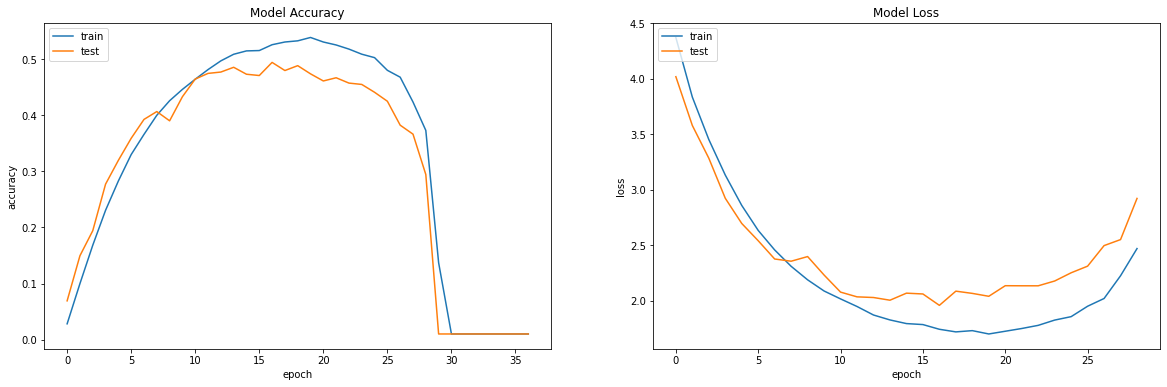

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel ='accuracy')
axs[0].set(xlabel ='epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='loss')
axs[1].set(xlabel='epoch')
axs[1].legend(['train', 'test'], loc='upper left')

**Prediction**

In [10]:
model.load_weights(path_best) 
y_pred = np.argmax(model.predict(x_test_norm), axis=-1)

In [11]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: ", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Precision:  0.5169434263497064
Recall:  0.4945
Accuracy:  0.4945
